In [297]:
%reload_ext autoreload
%autoreload 2
    
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

import tasks
import models

from sklearn.decomposition import PCA
from rastermap import Rastermap

device = "cuda" if torch.cuda.is_available() else "cpu"

filepath = Path("~/Documents/Kempner/MCN2024/jobs/")
filepath = filepath.expanduser()

from analysis import load_job, load_results, load_weight_changes, equal_axes, perturb_parameter
from analysis import create_stacked_output_plot, create_stacked_trial_plot

In [68]:
jobid = 47
init_prms, final_prms = load_weight_changes(jobid)

jobids = [43, 44, 45, 46, 47]
cols = 'krbgm'
color = cols[jobids.index(jobid)]

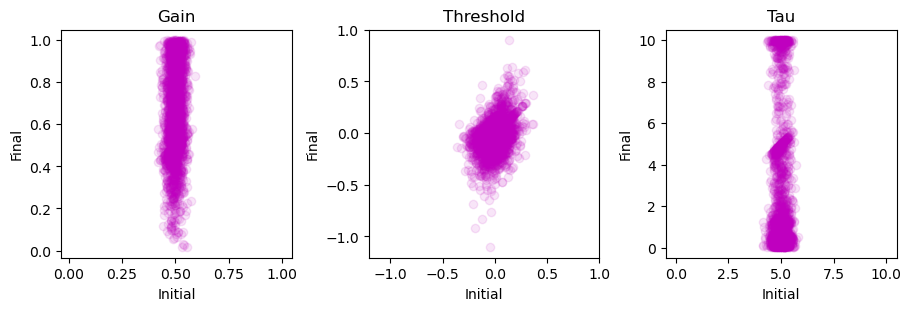

In [67]:

fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
ax[0].scatter(init_prms["hidden_gain"], final_prms["hidden_gain"], c=color, alpha=0.1)
ax[0].set_xlabel("Initial")
ax[0].set_ylabel("Final")
ax[0].set_title("Gain")
equal_axes(ax[0])

ax[1].scatter(init_prms["hidden_threshold"], final_prms["hidden_threshold"], c=color, alpha=0.1)
ax[1].set_xlabel("Initial")
ax[1].set_ylabel("Final")
ax[1].set_title("Threshold")
equal_axes(ax[1])

ax[2].scatter(init_prms["hidden_tau"], final_prms["hidden_tau"], c=color, alpha=0.1)
ax[2].set_xlabel("Initial")
ax[2].set_ylabel("Final")
ax[2].set_title("Tau")
equal_axes(ax[2])

figure_name = "weight_changes"
plt.savefig(f"../project/{figure_name}_{jobid}")
plt.show()

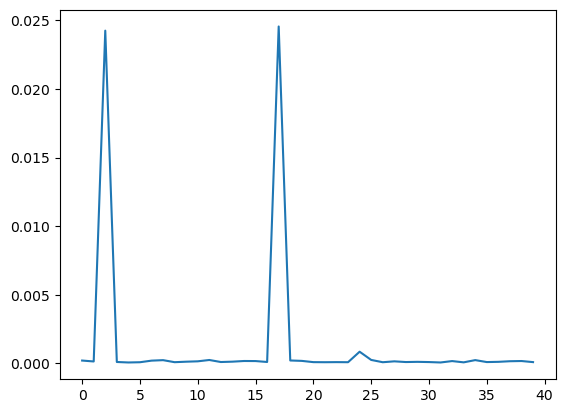

In [311]:
jobid = 52
train_loss, train_accuracy, train_evidence, train_fixation = load_results(jobid)

plt.close('all')
plt.plot(train_loss[:, -1])
plt.show()

In [312]:
# Load trained model and results

jobid = 52
model_index = 7
model, results, init_model = load_job(jobid, model_index=model_index, init=True)

args = results["args"]
task_params = results["task"]
train_loss = results["train_loss"]
train_accuracy = results["train_accuracy"]
train_evidence = results["train_evidence"]
train_fixation = results["train_fixation"]

task = tasks.ContextualGoNogo(
    args["input_dimensions"],
    args["end_sigma"],
    num_contexts=task_params["num_contexts"],
    stim_time=task_params["stim_time"],
    delay_time=args["end_delay"],
    decision_time=task_params["decision_time"],
    task_type=args["task_type"] if "task_type" in args else "embedded",
    mask=task_params["mask"] if "mask" in task_params else None,
)
task.cursors = task_params["cursors"]

net = models.build_model(args, task)
net.load_state_dict(model)

<All keys matched successfully>

In [313]:
X, target, params = task.generate_data(10000, sigma=0.1, source_floor=0.5, source_strength=1.0)
output, hidden = net(X, return_hidden=True)
output = output.detach()

context_idx = params["context_idx"]
labels = params["labels"]

context_axis = (hidden[context_idx == 0].mean(dim=0) - hidden[context_idx == 1].mean(dim=0)).mean(dim=0).detach().numpy()
choice_axis = (hidden[labels == 0].mean(dim=0) - hidden[labels == 1].mean(dim=0)).mean(dim=0).detach().numpy()
context_axis /= np.linalg.norm(context_axis)
choice_axis /= np.linalg.norm(choice_axis)

all_hidden = np.array(hidden.view(-1, hidden.size(2)).detach()).T
pca = PCA(n_components=4).fit(all_hidden.T)
isort = torch.tensor(np.argsort(pca.components_[0]))

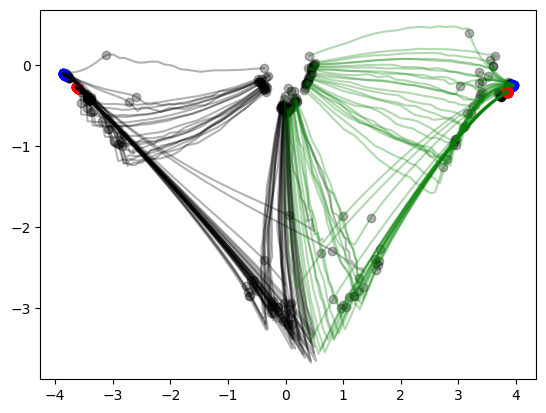

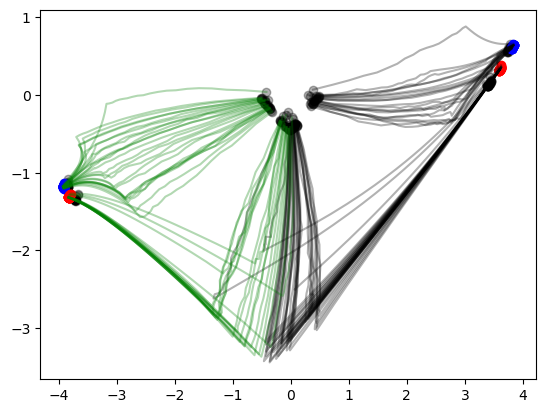

In [314]:
# task.decision_time = 
X, target, params = task.generate_data(100, source_floor=0.5, source_strength=1.5)
output, hidden = net(X, return_hidden=True)
output = output.detach()

decision_time = task.stim_time + task.delay_time

context_idx = params["context_idx"]
labels = params["labels"]

pc_hidden = hidden.detach().numpy() @ pca.components_.T[:, [0, 1]]

context_hidden = hidden.detach().numpy() @ context_axis
choice_hidden = hidden.detach().numpy() @ choice_axis

fig = plt.figure()
plt.plot(pc_hidden[context_idx==0, :, 0].T, pc_hidden[context_idx==0, :, 1].T, c='k', alpha=0.3)
plt.plot(pc_hidden[context_idx==1, :, 0].T, pc_hidden[context_idx==1, :, 1].T, c='g', alpha=0.3)
plt.scatter(pc_hidden[:, 0, 0], pc_hidden[:, 0, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[:, task.stim_time, 0], pc_hidden[:, task.stim_time, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[:, decision_time, 0], pc_hidden[:, decision_time, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[labels==0, -1, 0], pc_hidden[labels==0, -1, 1], c='b')
plt.scatter(pc_hidden[labels==1, -1, 0], pc_hidden[labels==1, -1, 1], c='r')
plt.show()

fig = plt.figure()
plt.plot(context_hidden[context_idx==0, :].T, choice_hidden[context_idx==0, :].T, c='k', alpha=0.3)
plt.plot(context_hidden[context_idx==1, :].T, choice_hidden[context_idx==1, :].T, c='g', alpha=0.3)
plt.scatter(context_hidden[:, 0], choice_hidden[:, 0], c='k', alpha=0.3)
plt.scatter(context_hidden[:, decision_time], choice_hidden[:, decision_time], c='k', alpha=0.3)
plt.scatter(context_hidden[labels==0, -1], choice_hidden[labels==0, -1], c='b')
plt.scatter(context_hidden[labels==1, -1], choice_hidden[labels==1, -1], c='r')
plt.show()

/Users/landauland/Documents/GitHub/mcn2024-psets/intrinsic-excitability/analysis.py:235: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.1)


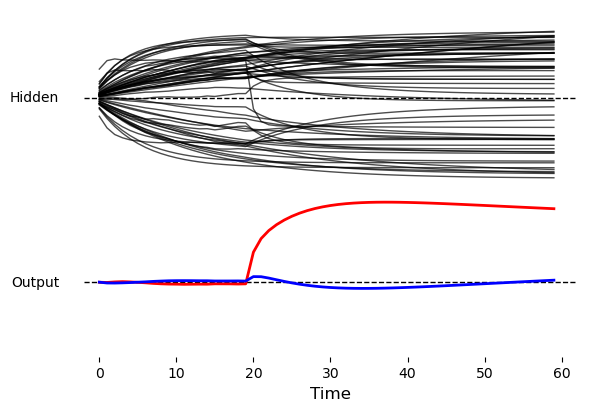

In [315]:
ibatch = 0

pnet = deepcopy(net)

targets = dict(
    gain="hidden_gain",
    threshold="hidden_threshold",
    tau="hidden_tau",
    receptive="reccurent_receptive",
    projective="reccurent_projective",
)

target_nonlinearity = dict(
    gain="sigmoid",
    threshold="linear",
    tau="sigmoid",
    receptive="linear",
    projective="linear",
)

do_perturb = True
if do_perturb:
    perturb_target = "tau"
    perturb_type = "rotation"
    perturb_ratio = np.pi/4

    old_parameter = getattr(pnet, targets[perturb_target])
    old_parameter = old_parameter.data
    if target_nonlinearity[perturb_target] == "sigmoid":
        old_parameter = torch.sigmoid(old_parameter)
    
    new_parameter = perturb_parameter(old_parameter, perturb_ratio, perturb_type)

    if target_nonlinearity[perturb_target] == "sigmoid":
        new_parameter = torch.clamp(new_parameter, 1e-6, 1 - 1e-6)
        new_parameter = torch.log(new_parameter / (1 - new_parameter))

    attribute = getattr(pnet, targets[perturb_target])
    attribute.data = new_parameter

task.decision_time = 10
# X, target, params = task.generate_data(1, source_floor=0.1, source_strength=0.3, sigma=0.3)
output, hidden = net(X, return_hidden=True)
output_perturbed, hidden_perturbed = pnet(X, return_hidden=True)

hidden = hidden.detach()
hidden_perturbed = hidden_perturbed.detach()

output = output.detach()
output_perturbed = output_perturbed.detach()

fig, ax = create_stacked_trial_plot(X, target, ibatch)
# # plt.savefig(f"../project/trial_example")
plt.show()

# Call the function (uncomment and adjust as needed)
fig, ax = create_stacked_output_plot(hidden, output, ibatch)
# plt.savefig(f"../project/trial_example_perturbation")
plt.show()